In [2]:
# !pip install captum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
from torch.utils.data.sampler import SubsetRandomSampler
import os
from datetime import datetime
import time
from IPython import display
from tqdm import tqdm
from typing import Dict, Callable, Tuple, Sequence, Union, Optional

%matplotlib inline

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.set_default_tensor_type(torch.FloatTensor)

from captum.attr import *

In [2]:
import sys
sys.path.append("..")

# import utils 
from utils.viz_tools import plot_central_cuts
from utils.data import MriSegmentation, MriClassification
from utils.routine import *
from models.cnn_model import *

In [3]:
all_data = MriClassification(sample='all', data_type = 'img', ignore_missing= True,
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')

  0%|          | 1/1404 [00:00<02:21,  9.91it/s]

Assembling data for:  all  sample.


100%|██████████| 1404/1404 [01:04<00:00, 21.80it/s]


In [4]:
def train_test_split(dataset, test_ratio=0.3, batch_size=2):
    ''' Returns train and validation dataloaders '''
    data_len = len(dataset)
    split_point = int(data_len * test_ratio)
    
    indexes = np.random.permutation(data_len)
    train_indices, val_indices = indexes[split_point:], indexes[:split_point]
    
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                            sampler=train_sampler, num_workers=8, drop_last=True)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                            sampler=valid_sampler, num_workers=8, drop_last=True)
    
    return train_loader, val_loader

In [5]:
train_loader, val_loader = train_test_split(all_data, test_ratio=0.3, batch_size=1)

In [6]:
iter(train_loader).next()[0].shape

torch.Size([1, 1, 192, 192, 192])

In [7]:
sample = iter(train_loader).next()[0]

In [8]:
import sys  
sys.path.insert(0, './models')
from AE_model_new import AE, Discriminator, Classificator

In [9]:
down_block_kwargs = {
    'conv_k': 6,
    'conv_pad': 2,
    'conv_s': 2,
    'maxpool_k': 2,
    'maxpool_s': 2,
    'batch_norm': True,
    'act': 'l_relu' ##'or l_relu'
}
up_block_kwargs = {
    'up': 'upsample',# or 'transpose_conv'
    'scale': 4,
    'scale_mode': 'nearest',
    'conv_k': 3,
    'conv_pad': 1,
    'conv_s': 1,
    'batch_norm': False,
    'act': 'l_relu' ##'or relu'
}
ae_kwargs ={
    'c_in':1,
    'is_skip': False,
    'deapth': 3,
    'c_base': 8,
    'inc_size':2,
    'reduce_size': False,
    'down_block_kwargs': down_block_kwargs,
    'up_block_kwargs': up_block_kwargs,
}
discriminator_kwargs = {
    'c_in': 32,
    'c_out':64,
    'conv_k': 3,
    'conv_s': 1,
    'conv_pad': 0,
    'l_in': 64,
    'l_out': 32,
    'batch_norm': True,
    'act': 'relu',
    'n_domains':18,
    'p_drop': 0.5,
    
}
classificator_kwargs = {
    'c_in': 32,
    'c_out':64,
    'conv_k': 3,
    'conv_s': 1,
    'conv_pad': 0,
    'l_in': 64,
    'l_out': 32,
    'batch_norm': True,
    'act': 'relu',
    'p_drop': 0.5,
    'n_class':2
}
n_domains = 18
encoder = AE(**ae_kwargs).enc
# disc = Discriminator(**discriminator_kwargs)
clf = Classificator(**classificator_kwargs)
model = AE(**ae_kwargs)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder.to(device)
clf.to(device);

In [11]:
encoder.load_state_dict(torch.load('./weights/encoder.pth', map_location='cuda:0'))
clf.load_state_dict(torch.load('./weights/clf.pth', map_location='cuda:0'))

<All keys matched successfully>

In [12]:
encoder.eval()
clf.eval();

In [13]:
class Net(nn.Module):
    def __init__(self, enc, clf):
        super(Net, self).__init__()
        self.enc = enc
        self.clf = clf
    
    def forward(self, x):
        x, _ = self.enc(x)
        x = self.clf(x)
        return x

In [14]:
net = Net(encoder, clf)
net.to(device)
net = net.float()
net.eval()
for param in net.parameters():
    param.requires_grad = False

In [15]:
DEFAULT_CUTOFF = 0.01, 0.99
STANDARD_RANGE = 0, 100

def _standardize_cutoff(cutoff: np.ndarray) -> np.ndarray:
    """Standardize the cutoff values given in the configuration.

    Computes percentile landmark normalization by default.

    """
    cutoff = np.asarray(cutoff)
    cutoff[0] = max(0., cutoff[0])
    cutoff[1] = min(1., cutoff[1])
    cutoff[0] = np.min([cutoff[0], 0.09])
    cutoff[1] = np.max([cutoff[1], 0.91])
    return cutoff



def _get_average_mapping(percentiles_database: np.ndarray) -> np.ndarray:
    """Map the landmarks of the database to the chosen range.

    Args:
        percentiles_database: Percentiles database over which to perform the
            averaging.
    """
    # Assuming percentiles_database.shape == (num_data_points, num_percentiles)
    pc1 = percentiles_database[:, 0]
    pc2 = percentiles_database[:, -1]
    s1, s2 = STANDARD_RANGE
    slopes = (s2 - s1) / (pc2 - pc1)
    slopes = np.nan_to_num(slopes)
    intercepts = np.mean(s1 - slopes * pc1)
    num_images = len(percentiles_database)
    final_map = slopes.dot(percentiles_database) / num_images + intercepts
    return final_map


def _get_percentiles(percentiles_cutoff: Tuple[float, float]) -> np.ndarray:
    quartiles = np.arange(25, 100, 25).tolist()
    deciles = np.arange(10, 100, 10).tolist()
    all_percentiles = list(percentiles_cutoff) + quartiles + deciles
    percentiles = sorted(set(all_percentiles))
    return np.array(percentiles)

def normalize(
        tensor,
        landmarks,
        mask = None,
        cutoff= None,
        epsilon= 1e-5,
        ):
    cutoff_ = DEFAULT_CUTOFF if cutoff is None else cutoff
    array = tensor.numpy()
    mapping = landmarks

    data = array
    shape = data.shape
    data = data.reshape(-1).astype(np.float32)

    if mask is None:
        mask = np.ones_like(data, np.bool)
    mask = mask.reshape(-1)

    range_to_use = [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12]

    quantiles_cutoff = _standardize_cutoff(cutoff_)
    percentiles_cutoff = 100 * np.array(quantiles_cutoff)
    percentiles = _get_percentiles(percentiles_cutoff)
    percentile_values = np.percentile(data[mask], percentiles)

    # Apply linear histogram standardization
    range_mapping = mapping[range_to_use]
    range_perc = percentile_values[range_to_use]
    diff_mapping = np.diff(range_mapping)
    diff_perc = np.diff(range_perc)

    # Handling the case where two landmarks are the same
    # for a given input image. This usually happens when
    # image background is not removed from the image.
    diff_perc[diff_perc < epsilon] = np.inf

    affine_map = np.zeros([2, len(range_to_use) - 1])

    # Compute slopes of the linear models
    affine_map[0] = diff_mapping / diff_perc

    # Compute intercepts of the linear models
    affine_map[1] = range_mapping[:-1] - affine_map[0] * range_perc[:-1]

    bin_id = np.digitize(data, range_perc[1:-1], right=False)
    lin_img = affine_map[0, bin_id]
    aff_img = affine_map[1, bin_id]
    new_img = lin_img * data + aff_img
    new_img = new_img.reshape(shape)
    new_img = new_img.astype(np.float32)
    new_img = torch.from_numpy(new_img)
    return new_img

def default_collate(batch):
    'batch = list of tuples(X, y, domain)'
    landmarks = np.load('./weights/fcd_train_data_landmarks.npy')
    X = torch.stack([normalize(item[0], landmarks) for item in batch])
    y = torch.LongTensor([item[1] for item in batch])    
    domain = torch.LongTensor([item[2] for item in batch]) 

    return X, y, domain

In [16]:
holdout_idx = all_data.scan[all_data.scan == 4]

In [17]:
test_data_0 = Subset(all_data, holdout_idx)
test_loader_0 = torch.utils.data.DataLoader(test_data_0, batch_size=1, 
                             num_workers=0, drop_last=False, collate_fn=default_collate)

In [18]:
sample_X, sample_y, sample_domain = iter(test_loader_0).next()

In [20]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=1,
                                              **kwargs
                                             )
    
    return tensor_attributions

In [21]:
sample_X.requires_grad = True

In [22]:
saliency = Saliency(net.cpu())
grads = saliency.attribute(sample_X.cpu(), target=1)
# grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [25]:
def draw_mask(mask):
#     mask = mask[0][0]
    mask_shape = mask.shape
    x, y, z, c = [], [], [], []
    
    for i in range(mask_shape[0]):
        for j in range(mask_shape[1]):
            for k in range(mask_shape[2]):
                val = mask[i][j][k]
                if val > 0:
                    x.append(i)
                    y.append(j)
                    z.append(k)
                    c.append(val)
    
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    ax.scatter3D(x, y, z)
    plt.show()

In [30]:
def thres_mask(heatmap, t=0):
#     thres = heatmap.mean() * 200
    ones = np.ones(heatmap.shape)
    mask = (heatmap > t)
    try:
        return mask.astype(int)
    except:
        mask = mask.numpy()
        return mask.astype(int)

In [27]:
# grads = grads * 1e5

In [28]:
grads.min(), grads.mean(), grads.max(), grads.shape

(tensor(1.7340e-14),
 tensor(1.6063e-05),
 tensor(0.0008),
 torch.Size([1, 1, 192, 192, 192]))

In [31]:
grads_mask = thres_mask(grads[0][0], 2e-4)

In [32]:
grads_mask.sum() / (192 * 192 * 192)

0.0013937773527922454

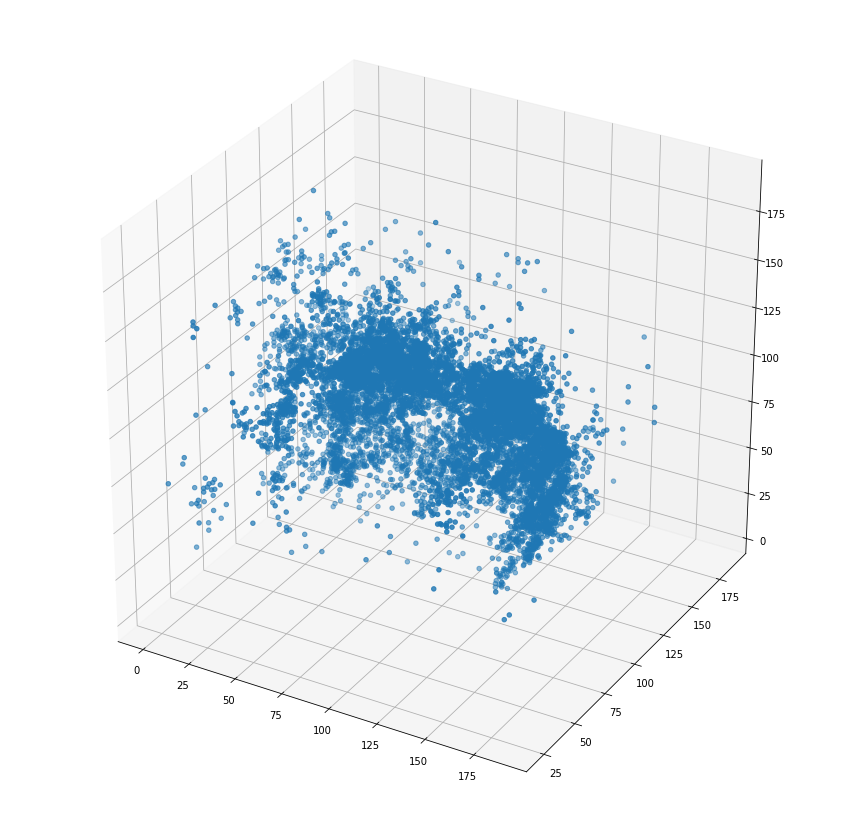

In [33]:
draw_mask(grads_mask)

In [ ]:
# with open('mask_1_gradcam2.npy', 'wb') as f:
#     np.save(f, gc_mask)

In [37]:
grad_cam = GuidedGradCam(net.cpu(), net.enc.encode[0].block['1_convx'])
gc = grad_cam.attribute(sample_X.cpu(), target=1)

/trinity/home/s.nesteruk/.local/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


In [38]:
gc = gc.detach().cpu().numpy()

In [39]:
gc = gc * 1e9

In [40]:
gc.min(), gc.mean(), gc.max()

(-0.15129101, 9.2240505e-08, 0.1200533)

In [41]:
gc_mask = thres_mask(gc[0][0], 0.01)
gc_mask.sum() / (192 * 192 * 192)

0.00013718781647858796

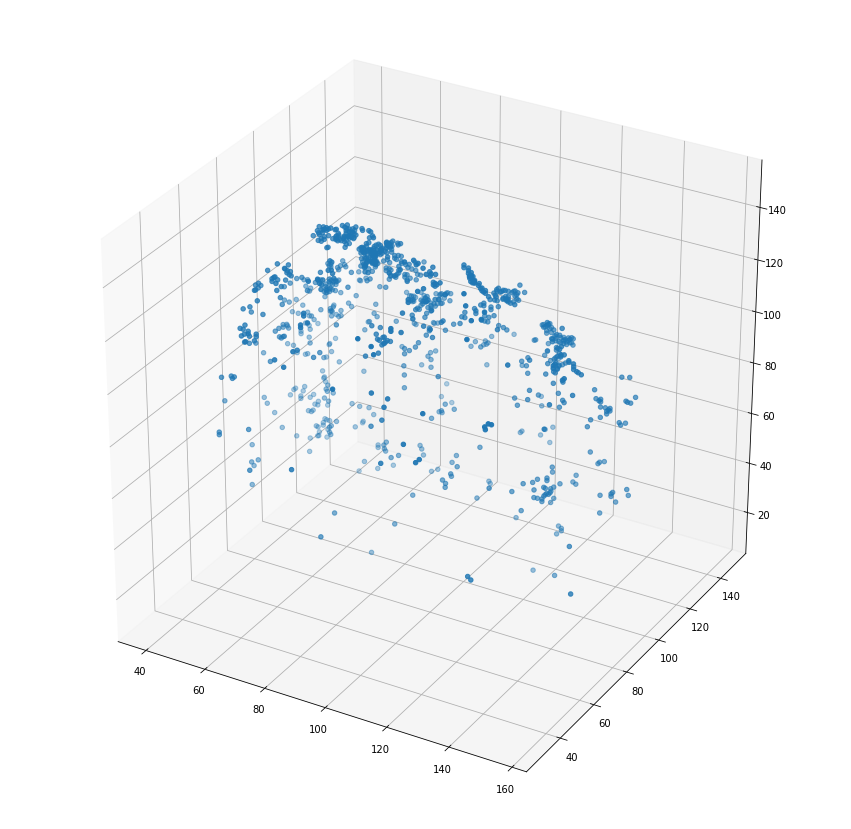

In [42]:
draw_mask(gc_mask)

In [35]:
from nilearn import plotting
import nibabel as nib
import nilearn

/trinity/shared/opt/python-3.7.1/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


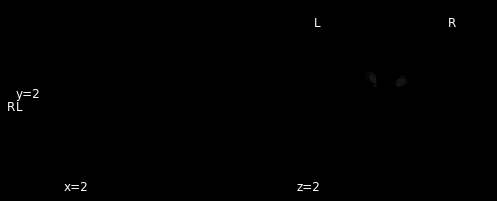

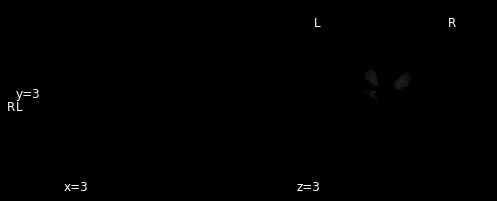

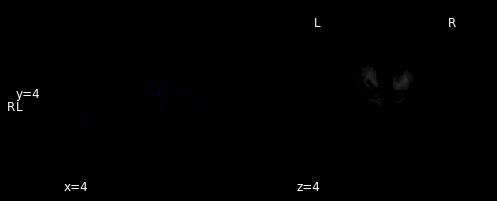

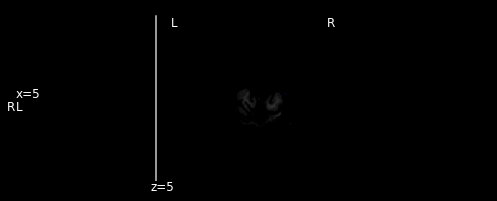

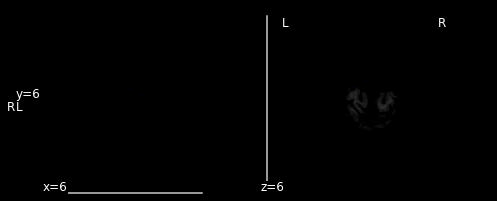

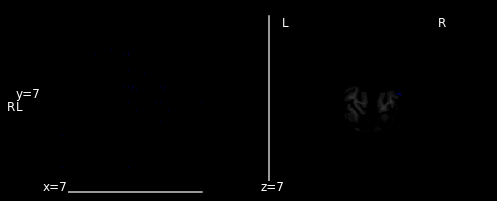

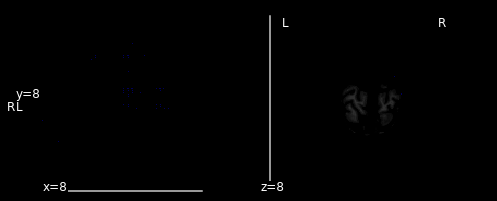

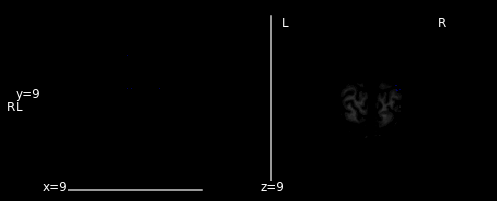

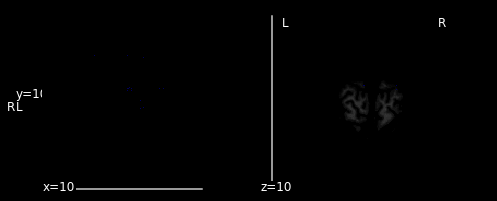

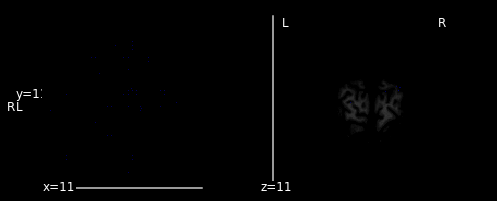

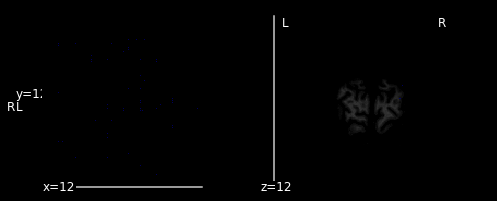

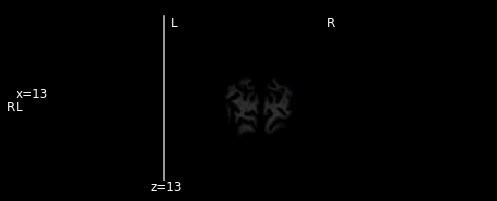

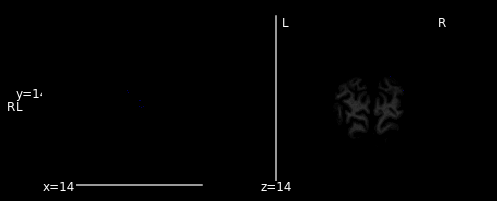

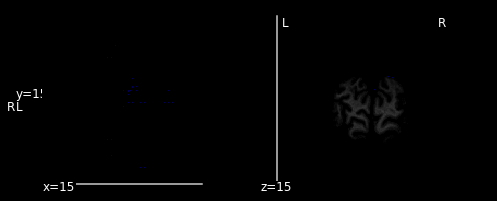

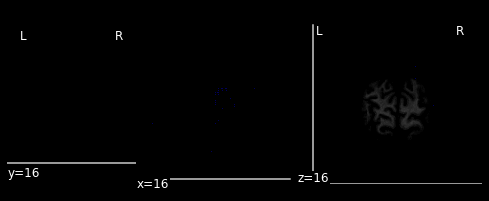

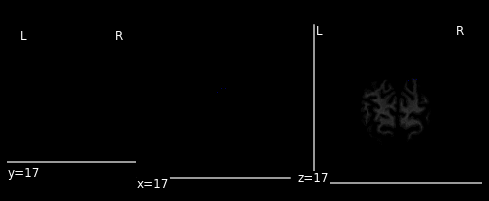

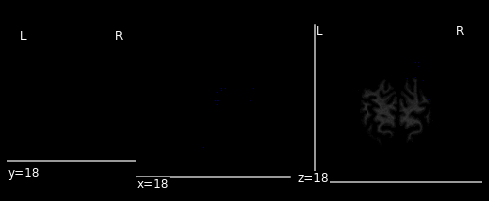

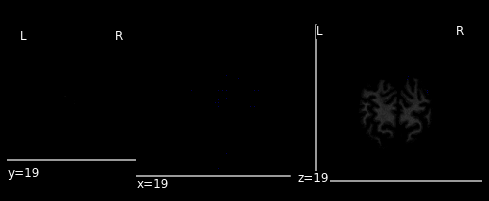

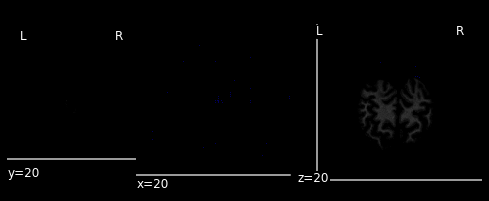

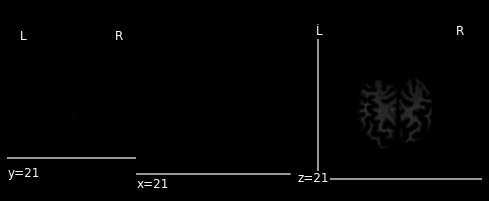

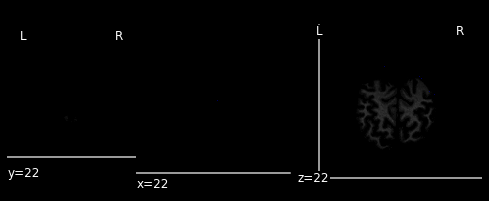

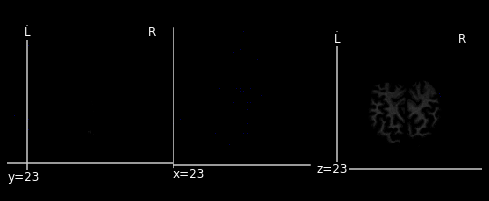

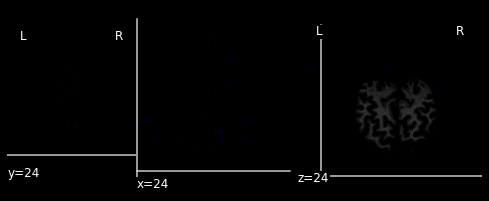

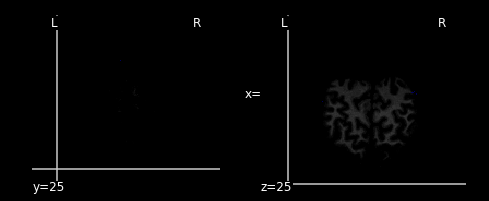

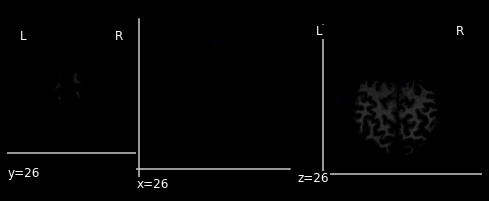

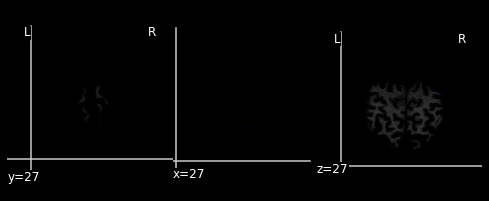

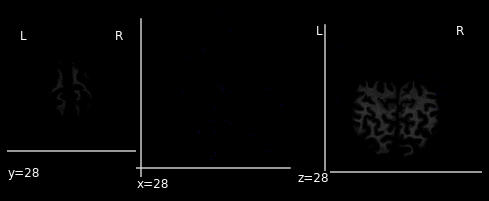

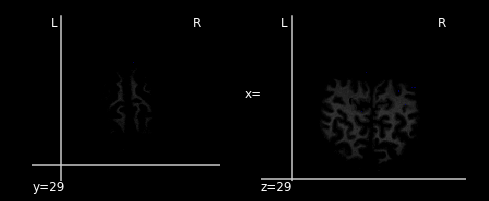

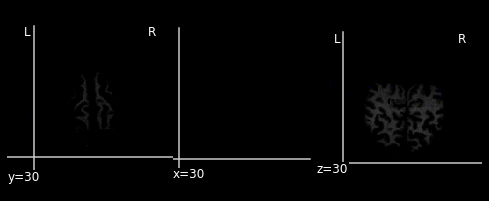

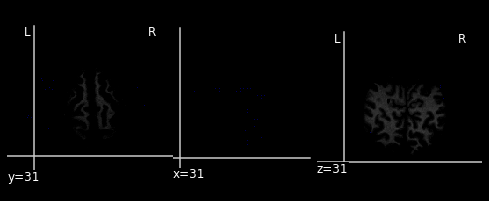

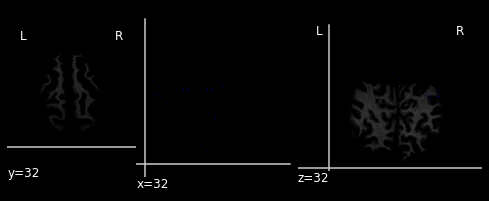

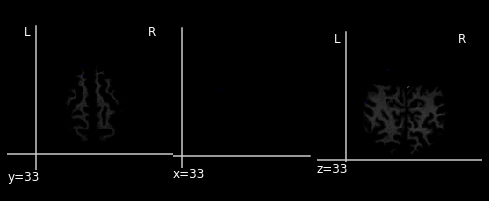

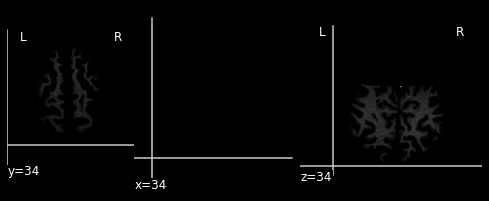

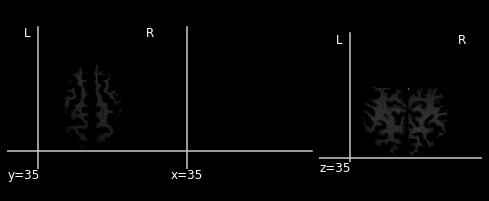

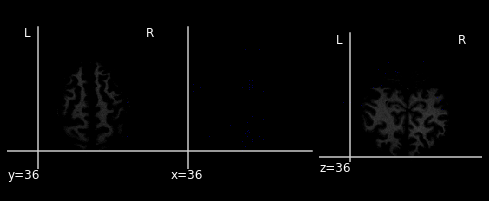

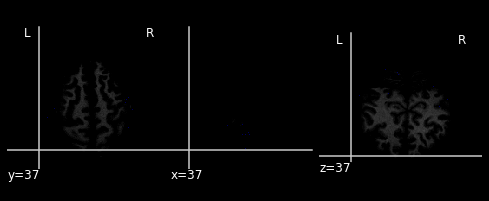

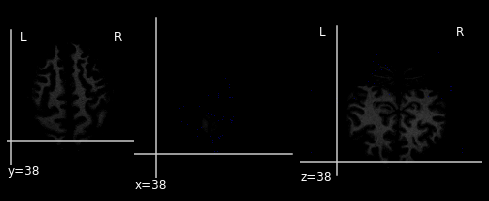

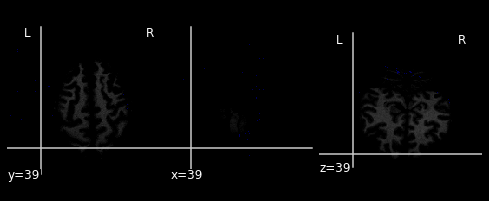

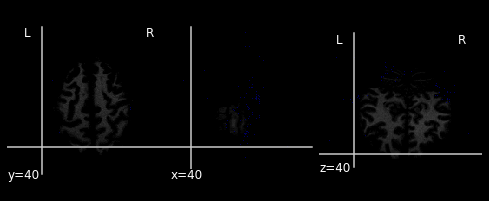

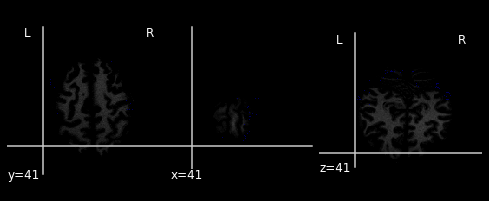

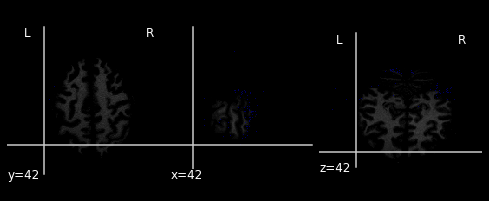

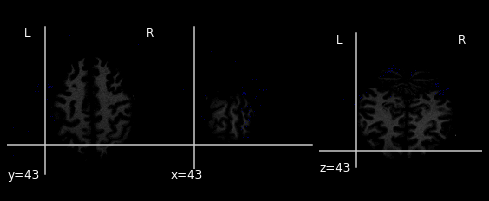

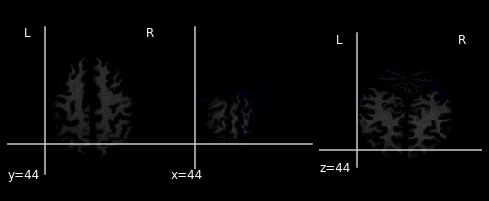

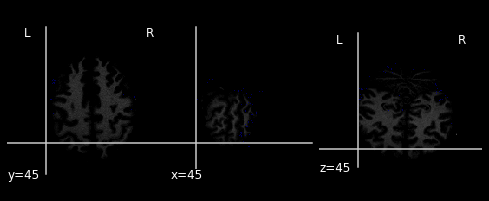

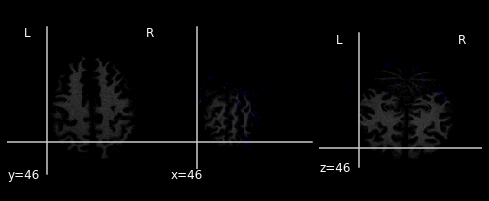

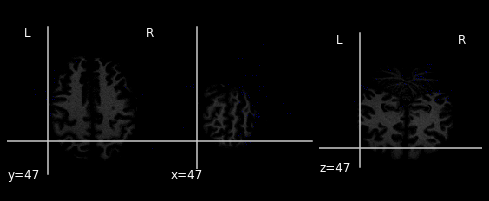

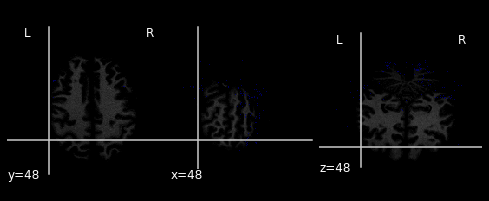

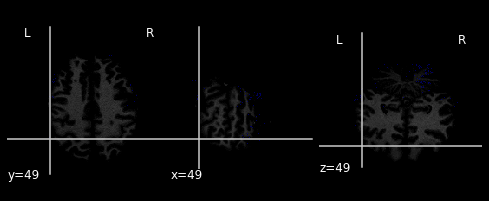

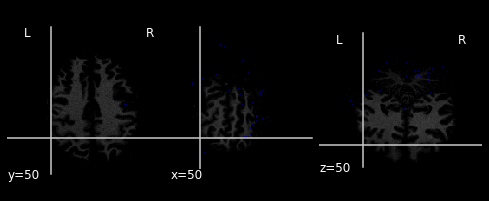

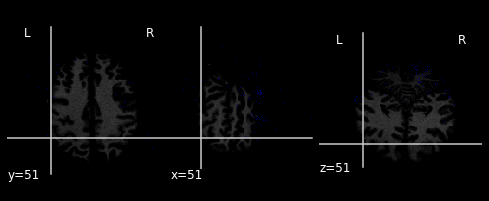

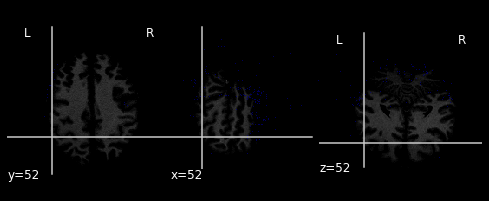

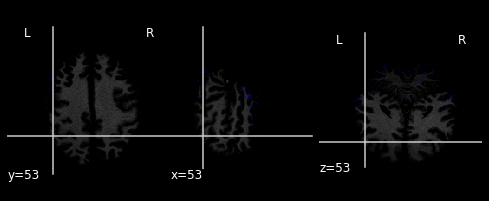

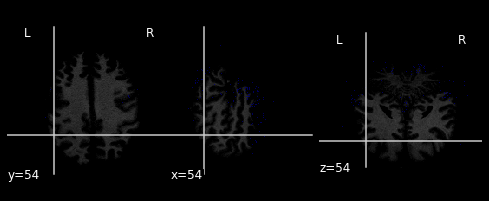

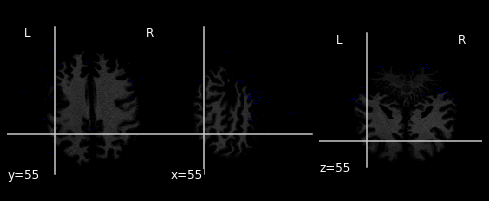

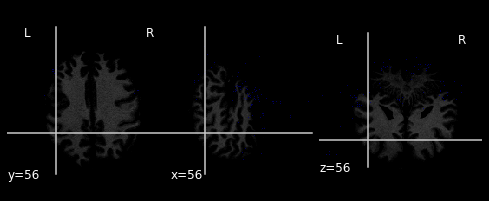

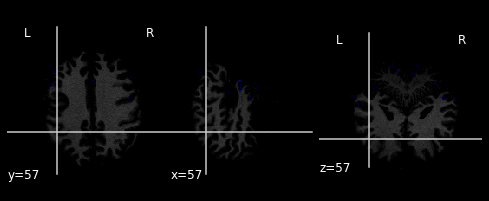

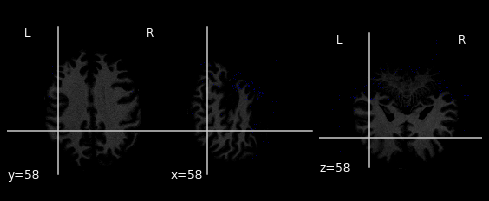

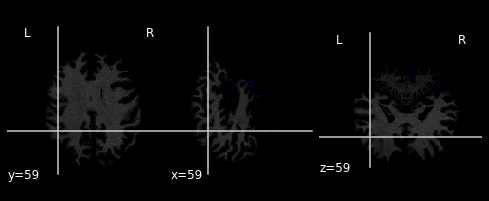

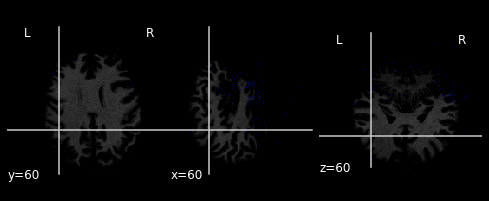

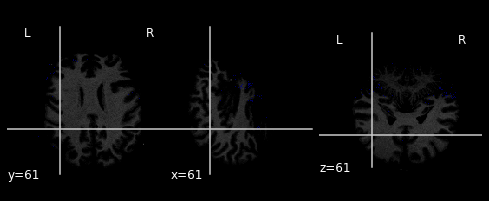

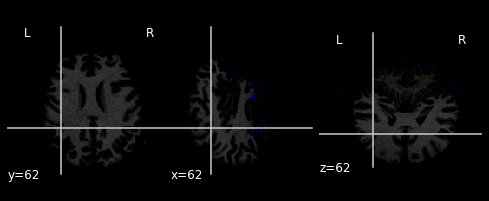

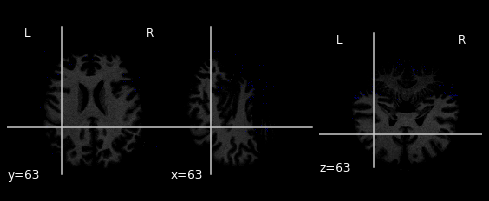

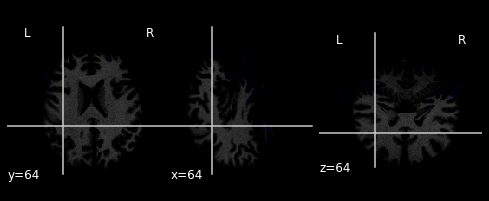

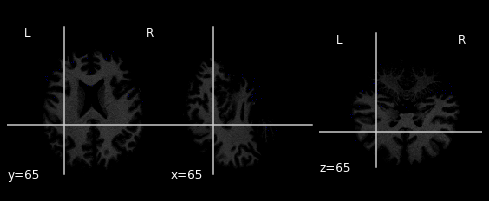

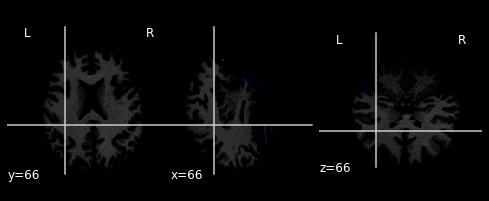

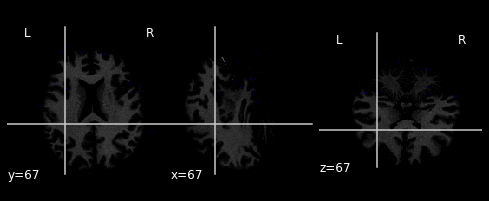

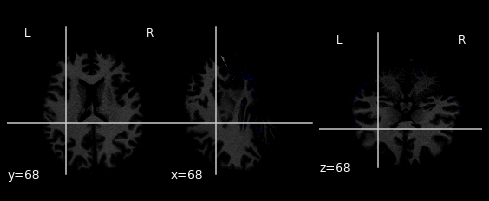

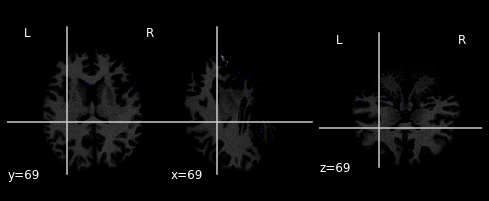

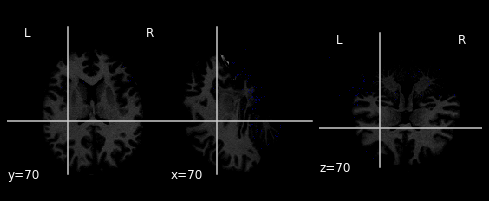

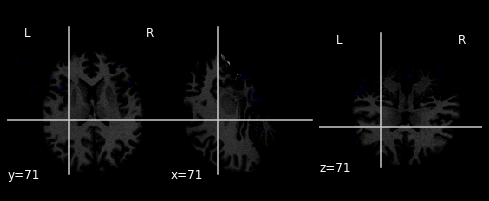

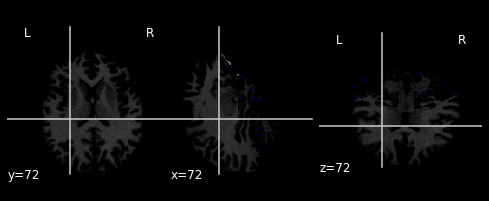

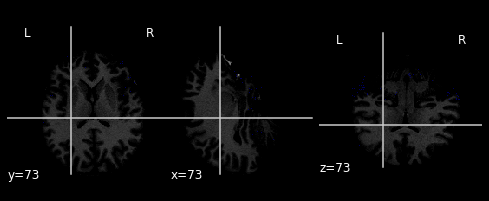

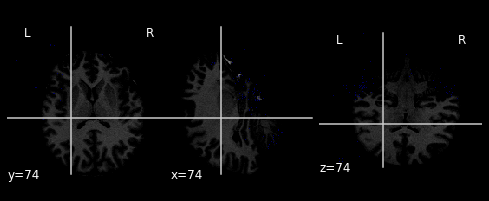

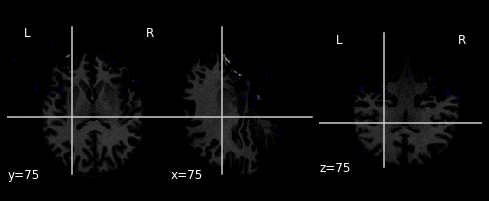

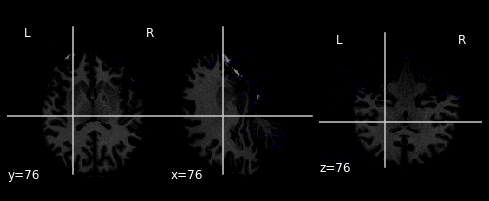

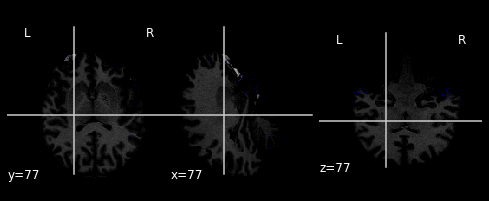

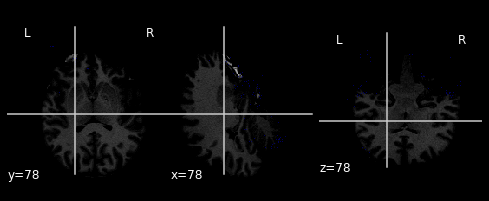

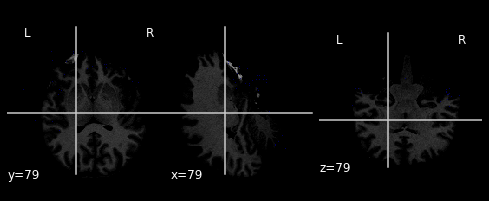

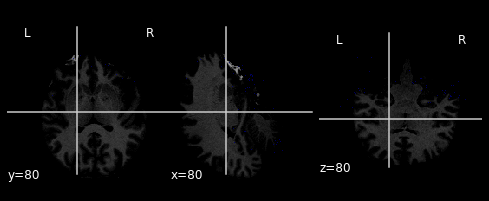

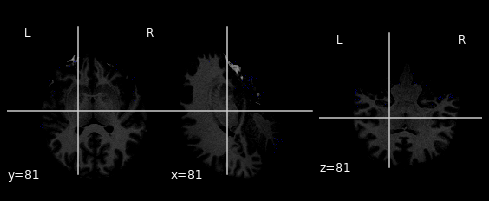

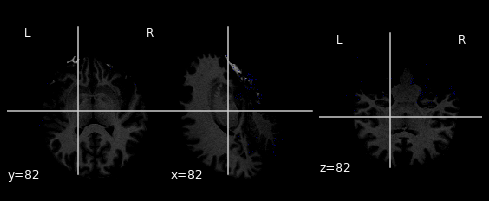

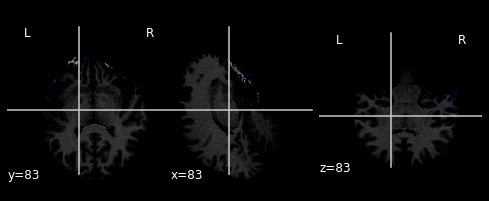

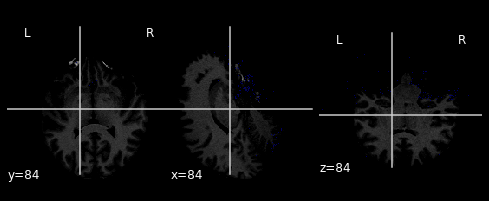

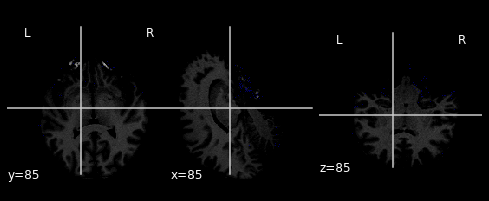

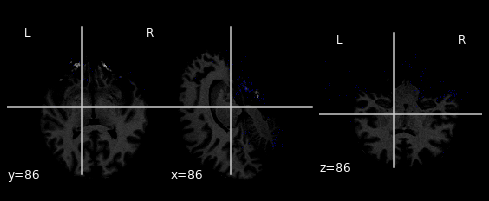

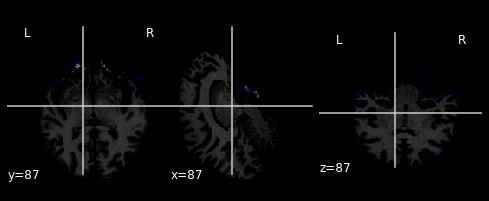

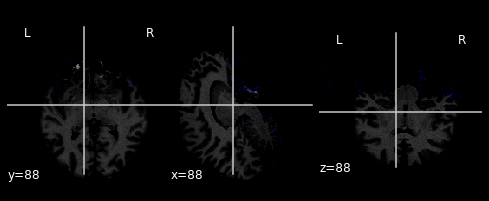

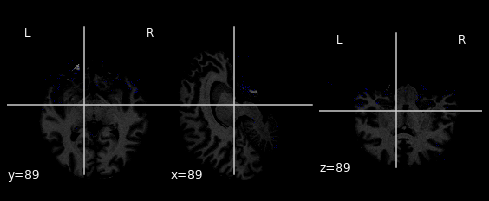

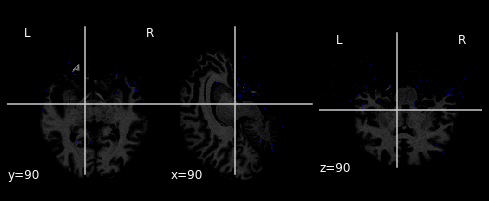

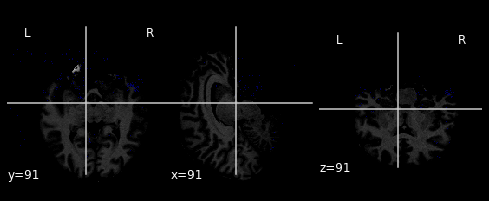

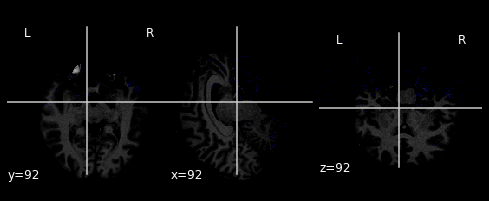

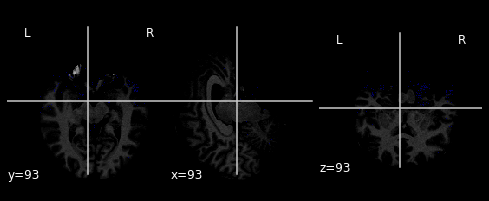

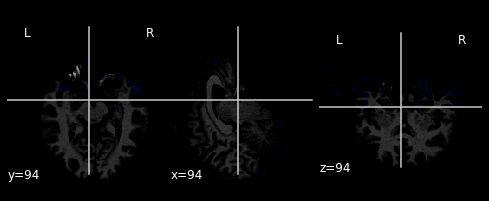

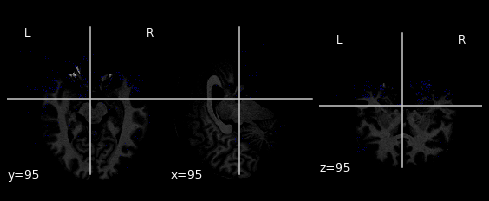

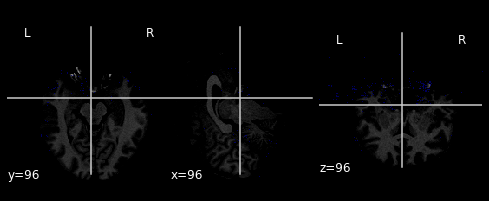

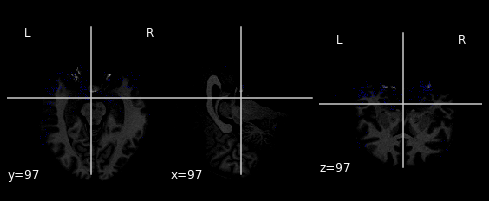

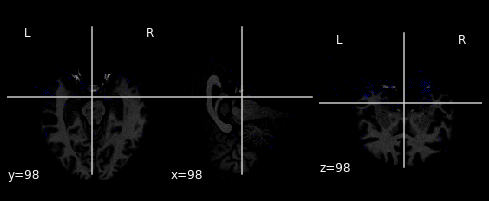

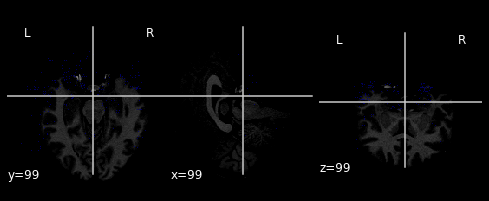

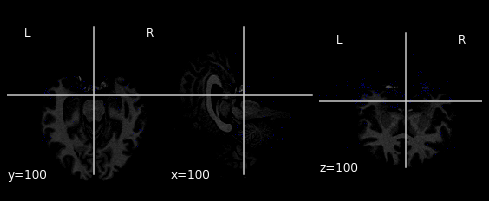

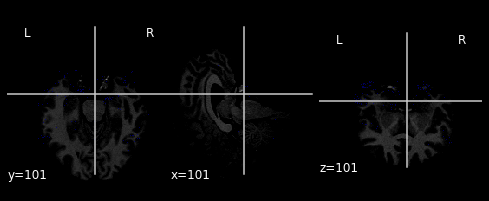

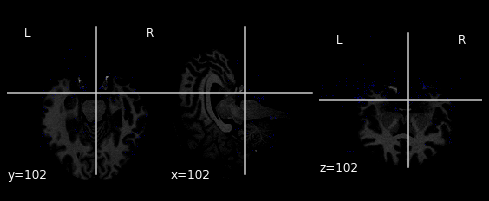

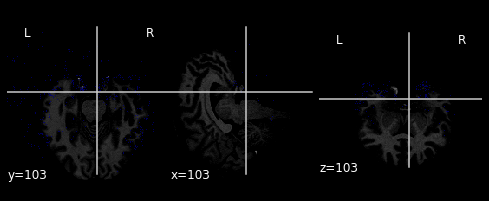

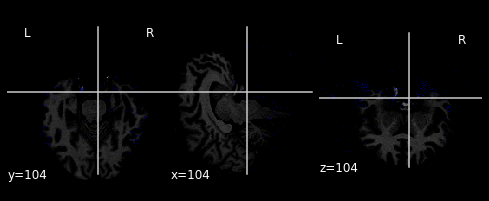

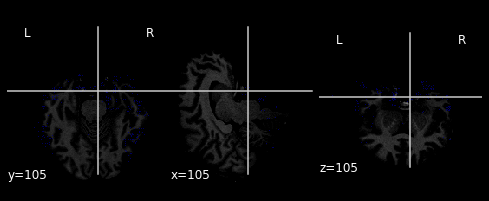

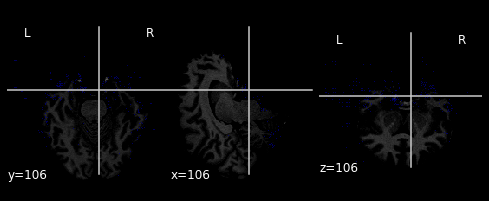

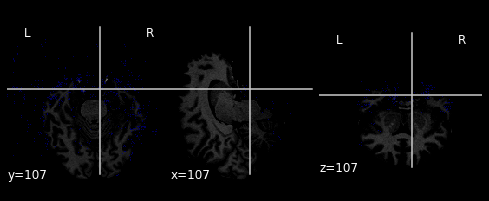

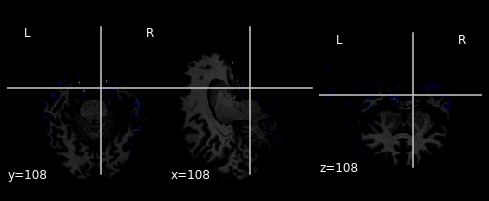

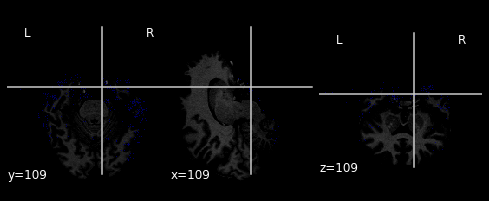

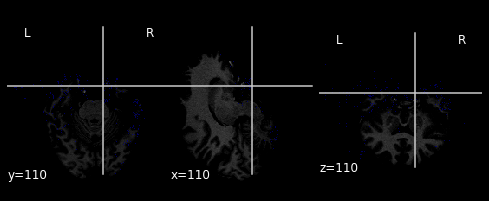

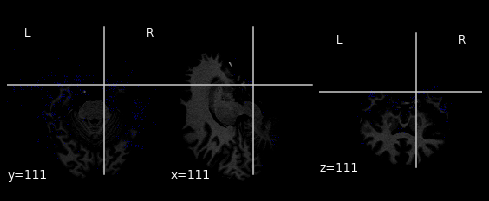

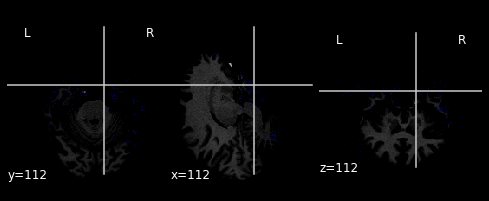

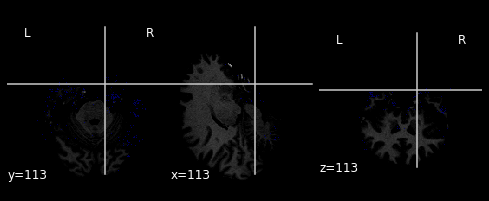

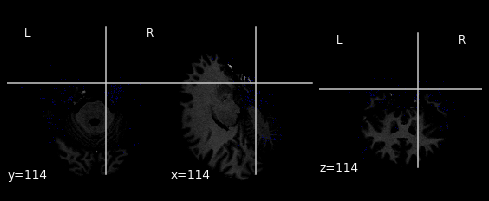

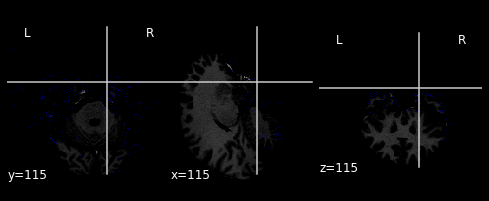

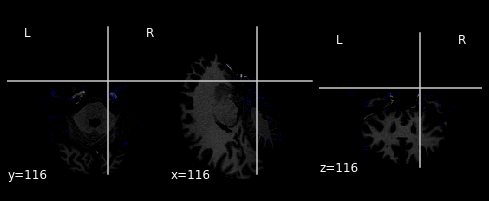

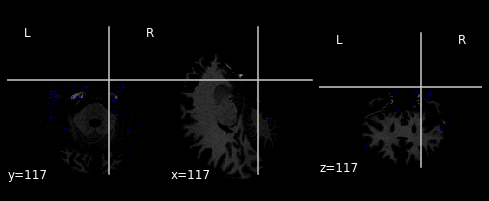

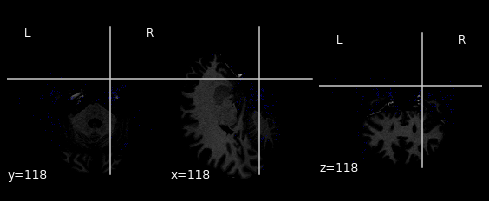

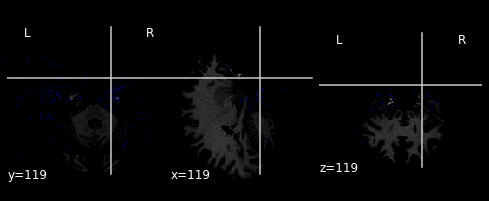

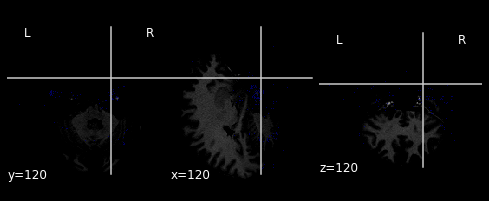

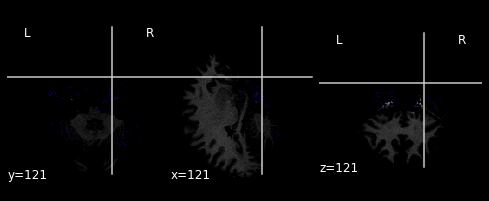

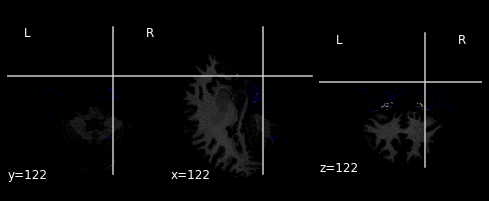

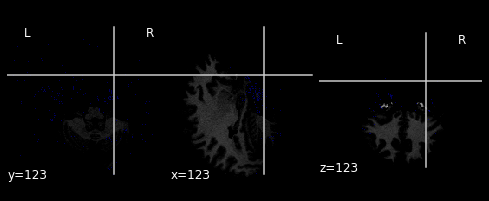

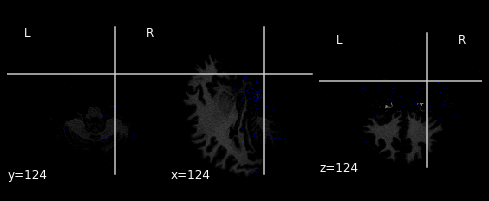

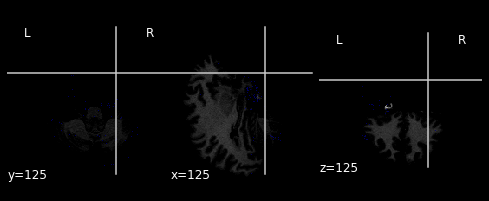

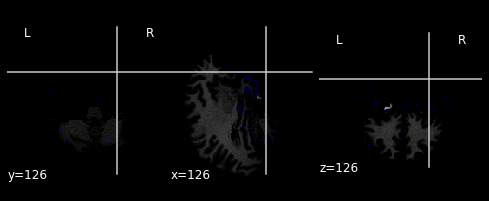

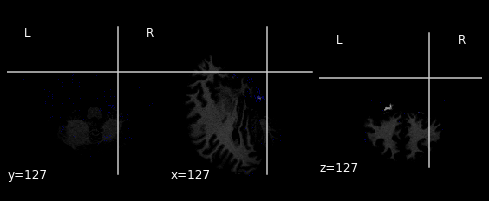

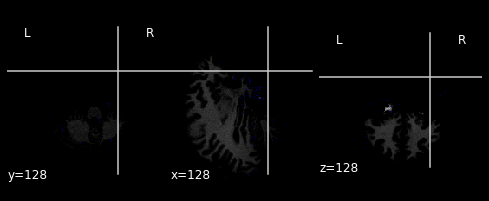

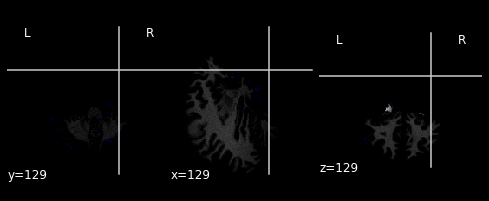

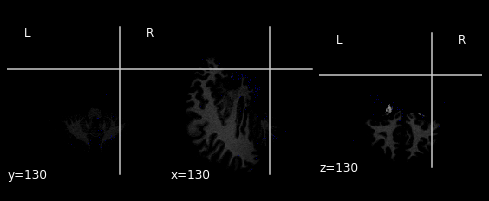

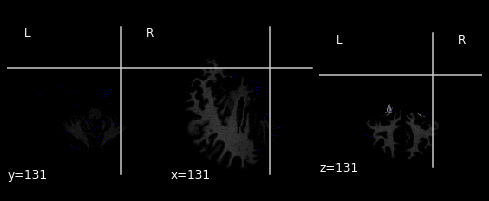

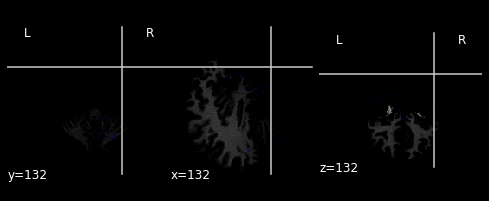

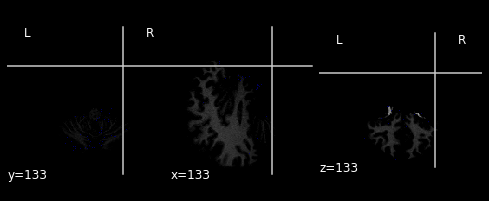

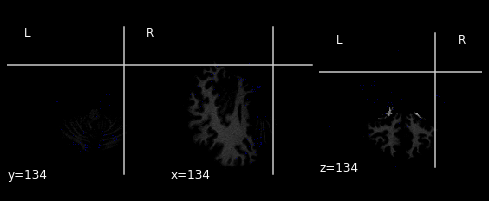

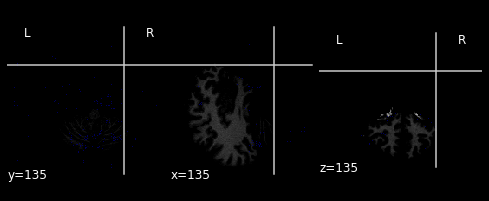

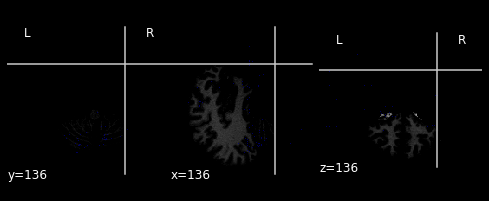

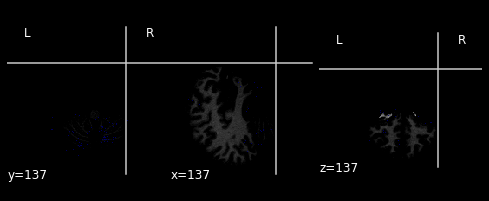

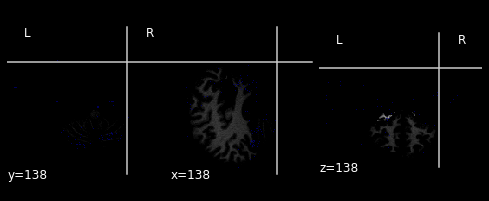

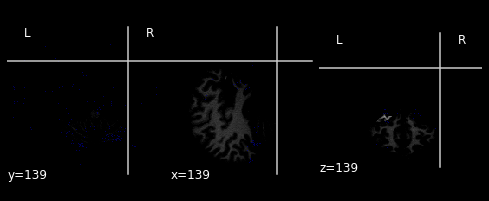

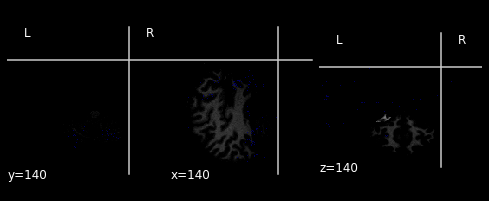

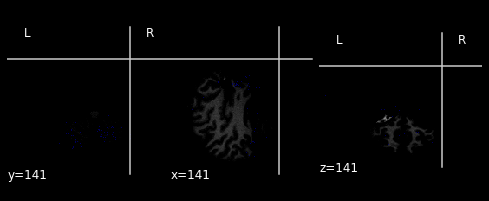

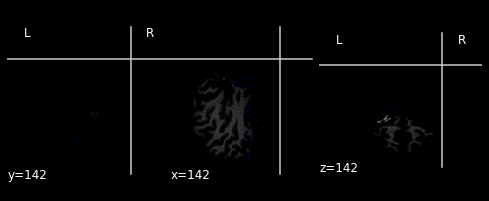

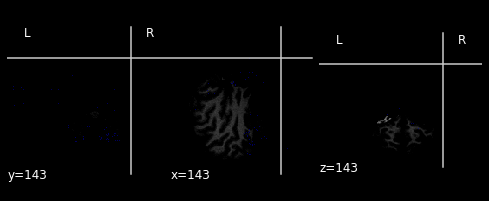

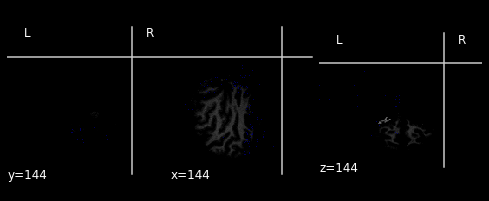

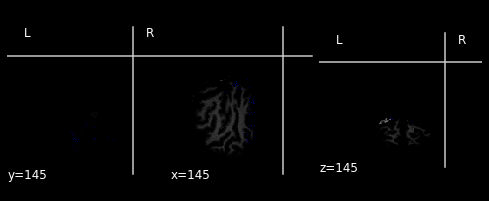

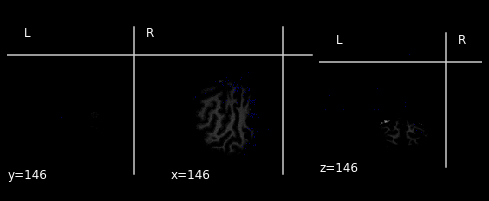

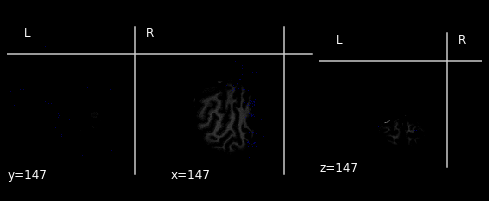

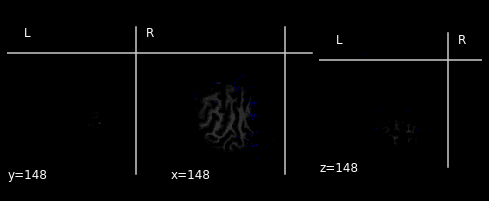

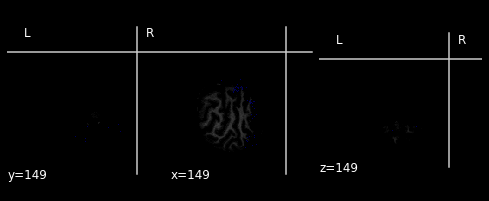

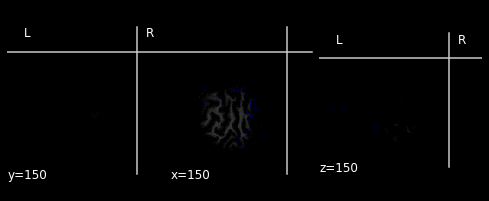

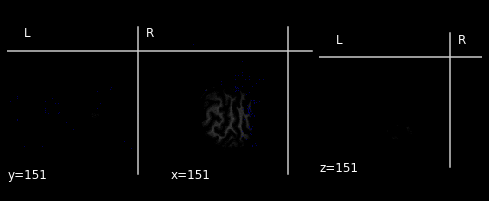

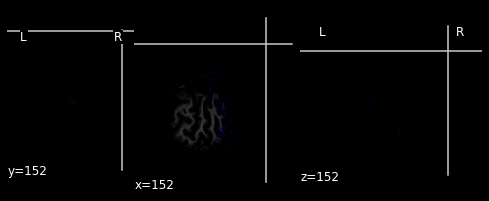

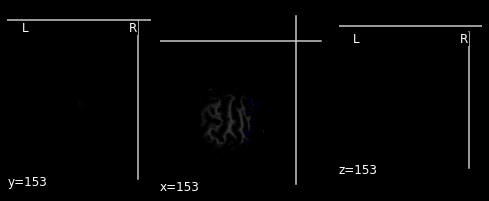

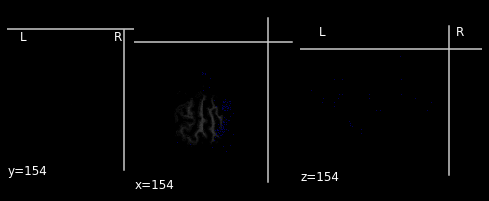

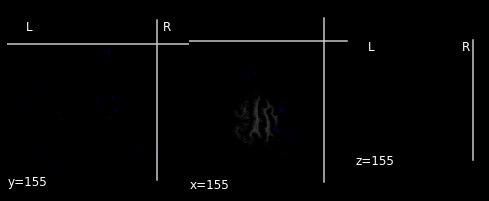

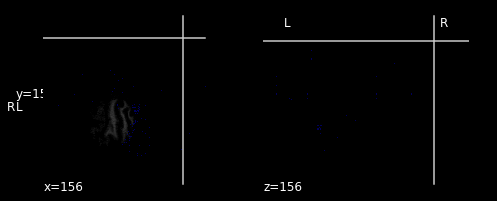

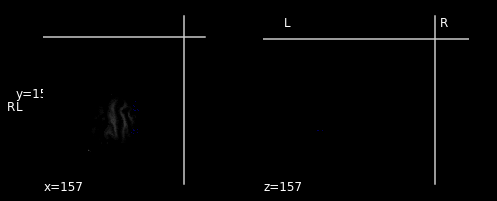

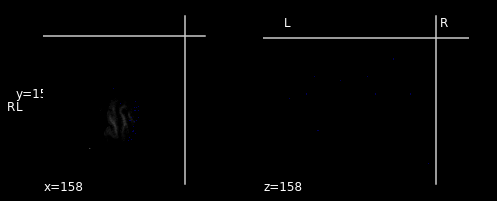

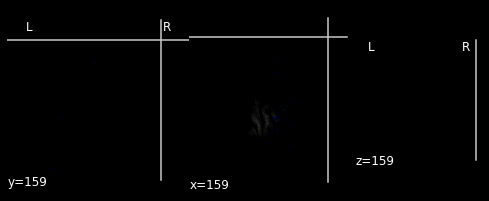

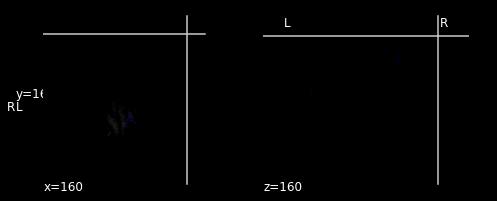

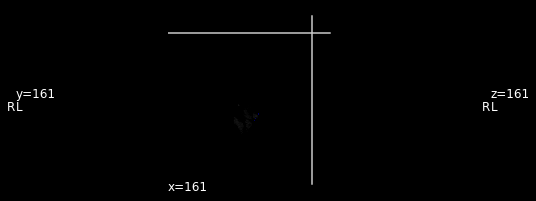

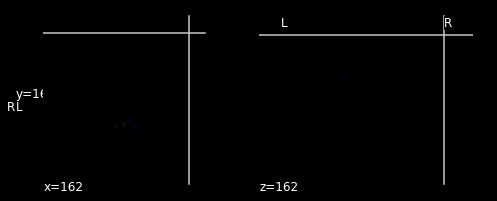

In [36]:
roi_img = nib.Nifti1Image( np.squeeze(grads_mask * 100),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(sample_X.detach().cpu().numpy()),affine=np.eye(4))
for i in range(2, 163):
    plotting.plot_roi(roi_img,bim_img,cut_coords=(i,i,i))
    plotting.show()